<a href="https://colab.research.google.com/github/MarwanElsays/Action-Recognition/blob/main/Action_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Action Recognition using ConvLSTM**

In [8]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    ConvLSTM2D, MaxPooling3D, Flatten, Dense, BatchNormalization,
    Dropout, TimeDistributed, Conv2D, Input
)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

## Download UCF50 dataset

In [9]:
%%capture

# !pip install yt-dlp

# Download the datset
# !wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar -O UCF50.rar

# # extract the files
# !unrar x UCF50.rar

## Extract vedio frames and labels

In [10]:
DATASET_DIR = '/content/UCF50/'
IMG_SIZE = (128,128)
SEQUENCE_LENGTH = 30
BATCH_SIZE = 4
CLASSES = ['JumpingJack','Punch','TaiChi']
#CLASSES = sorted(os.listdir(DATASET_DIR))

In [11]:
def extract_video_frames(video_file):
    cap = cv2.VideoCapture(video_file)
    frames = []

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Total number of frames in the video
    step = max(1, total_frames // SEQUENCE_LENGTH)  # Calculate the step size to sample frames

    frame_count = 0
    while frame_count < total_frames:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_count)  # Set the frame position
        ret, frame = cap.read()
        if not ret:
            break

        # Resize the frame
        frame_resized = cv2.resize(frame, IMG_SIZE)
        # Normalize the frame (scaling pixel values to [0, 1])
        frame_normalized = frame_resized / 255.0
        frames.append(frame_normalized)

        frame_count += step  # Increment frame count by step size

    cap.release()

    # Ensure the final output has exactly SEQUENCE_LENGTH frames
    if len(frames) > SEQUENCE_LENGTH:
        frames = frames[:SEQUENCE_LENGTH]  # Truncate extra frames

    return np.array(frames)

# Function to process all videos in the dataset and separate data and labels
def extract_all_frames_and_labels(dataset_path,classes):
    all_frames = []
    all_labels = []

    for label, category in enumerate(classes):
        print(f"Processing category: {category}")
        category_path = os.path.join(dataset_path, category)
        if not os.path.isdir(category_path):
            continue

        for video_name in os.listdir(category_path):
            video_path = os.path.join(category_path, video_name)

            # Extract and process frames from the video
            frames = extract_video_frames(video_path)
            if frames.shape[0] == SEQUENCE_LENGTH:
                all_frames.append(frames)
                all_labels.append(label)

    # Convert lists to NumPy arrays
    all_frames = np.array(all_frames, dtype=np.float32)
    all_labels = np.array(all_labels, dtype=np.int32)

    return all_frames, all_labels

In [12]:
all_frames, all_labels = extract_all_frames_and_labels(DATASET_DIR,CLASSES)
all_labels = to_categorical(all_labels)

Processing category: JumpingJack
Processing category: Punch
Processing category: TaiChi


In [13]:
# print(all_frames[1])
print(all_labels[1])

[1. 0. 0.]


In [14]:
print(all_frames.shape)
print(all_labels.shape)

(383, 30, 128, 128, 3)
(383, 3)


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
        all_frames, all_labels, test_size=0.1, shuffle = True,random_state=42
    )

## Create the model

In [16]:
# Function to build the model
def build_deep_convlstm(sequence_length, img_height, img_width, num_classes):

    model = Sequential([
        Input(shape=(sequence_length, img_height, img_width, 3), name='input_layer'),

        ConvLSTM2D(30, kernel_size=(3, 3), padding='same', return_sequences=True,
                   activation='tanh',recurrent_dropout=0.2),
        BatchNormalization(),
        MaxPooling3D(pool_size=(1, 2, 2), padding='same'),

        ConvLSTM2D(25, kernel_size=(3, 3), padding='same', return_sequences=True,
                   activation='tanh',recurrent_dropout=0.2),
        BatchNormalization(),
        MaxPooling3D(pool_size=(1, 2, 2), padding='same'),

        ConvLSTM2D(15, kernel_size=(3, 3), padding='same', return_sequences=True,
                   activation='tanh',recurrent_dropout=0.2),
        BatchNormalization(),
        MaxPooling3D(pool_size=(1, 2, 2), padding='same'),

        ConvLSTM2D(10, kernel_size=(3, 3), padding='same', return_sequences=False,
                   activation='tanh',recurrent_dropout=0.2),
        BatchNormalization(),

        Flatten(),
        Dense(num_classes, activation='softmax')
    ])

    return model

# Function to compile and prepare model
def prepare_model(model, learning_rate=0.001):
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Create callbacks
def get_callbacks(model_name):
    return [
        ModelCheckpoint(
            f'best_{model_name}.keras',
            monitor='val_loss',
            save_best_only=True,
            mode='min'
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            mode='min'
        ),
        # ReduceLROnPlateau(
        #     monitor='val_loss',
        #     factor=0.2,
        #     patience=5,
        #     min_lr=1e-6
        # )
    ]

In [17]:
model = build_deep_convlstm(SEQUENCE_LENGTH, IMG_SIZE[0], IMG_SIZE[1], len(CLASSES))
model = prepare_model(model)

### Model Summary

In [18]:
#plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True, dpi=60)

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)             │ (None, 30, 128, 128, 30)    │          35,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 30, 128, 128, 30)    │             120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 30, 64, 64, 30)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)           │ (None, 30, 64, 64, 25)      │          49,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 30, 64, 64, 25)      │             100 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 30, 32, 32, 25)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)           │ (None, 30, 32, 32, 15)      │          21,660 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 30, 32, 32, 15)      │              60 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 30, 16, 16, 15)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)           │ (None, 16, 16, 10)          │           9,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 10)          │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2560)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │           7,683 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 124,063 (484.62 KB)

 Trainable params: 123,903 (484.00 KB)

 Non-trainable params: 160 (640.00 B)

### Train Model

In [20]:
# model = load_model('best_deep_convlstm_model.keras')

In [21]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_split=0.2,
    callbacks=get_callbacks("deep_convlstm_model"),
    verbose=1
)

Epoch 1/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 90s 864ms/step - accuracy: 0.5889 - loss: 1.0804 - val_accuracy: 0.4493 - val_loss: 0.9248
Epoch 2/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 31s 455ms/step - accuracy: 0.8110 - loss: 0.4073 - val_accuracy: 0.6232 - val_loss: 0.9131
Epoch 3/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 42s 472ms/step - accuracy: 0.8831 - loss: 0.3379 - val_accuracy: 0.7246 - val_loss: 0.7171
Epoch 4/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 40s 461ms/step - accuracy: 0.9433 - loss: 0.2139 - val_accuracy: 0.7536 - val_loss: 0.6084
Epoch 5/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 41s 463ms/step - accuracy: 0.9105 - loss: 0.2123 - val_accuracy: 0.7681 - val_loss: 0.4534
Epoch 6/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 41s 465ms/step - accuracy: 0.9743 - loss: 0.1034 - val_accuracy: 0.8261 - val_loss: 0.4850
Epoch 7/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 42s 478ms/step - accuracy: 0.9724 - loss: 0.0965 - val_accuracy: 0.5507 - val_loss: 2.5776
Epoch 8/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 33s 481ms/step - accuracy: 0.9370 - loss: 0.1712 - val_accu

## Graph

In [22]:
import matplotlib.pyplot as plt

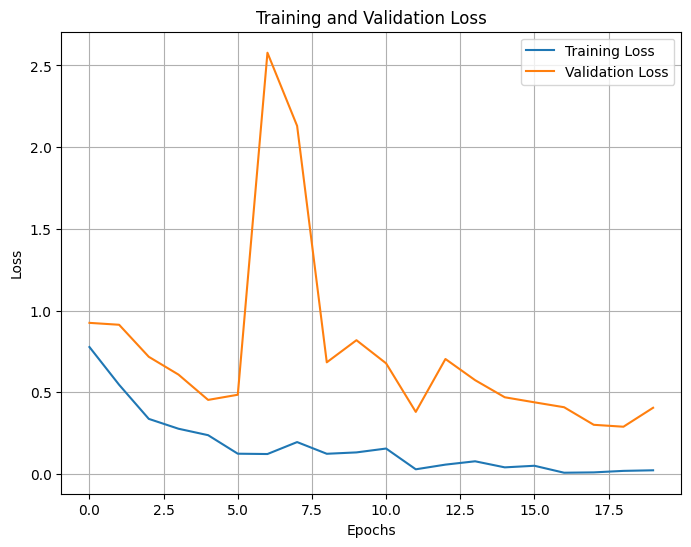

In [23]:
# Extract loss and validation loss from history
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot loss vs validation loss
plt.figure(figsize=(8, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Plot Accuracy and Validation Accuracy

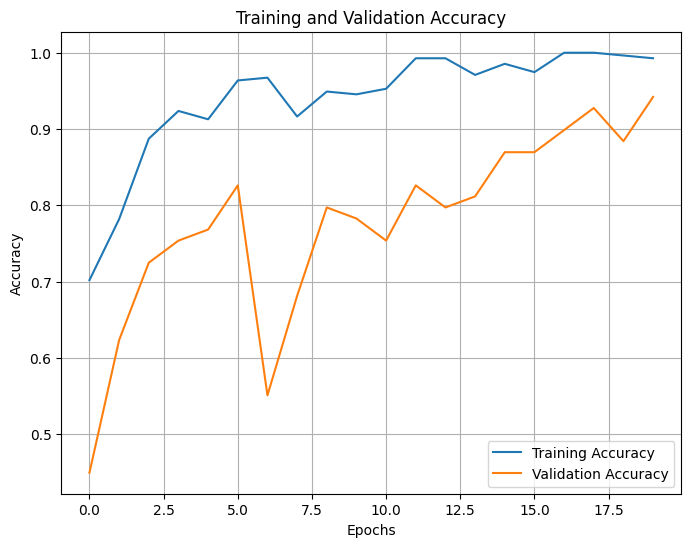

In [24]:
# Extract accuracy and validation accuracy from history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot accuracy vs validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Test the model

In [25]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=4)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 298ms/step - accuracy: 0.9784 - loss: 0.1052
Test Loss: 0.13735906779766083
Test Accuracy: 0.9743589758872986


## Detect on vedios from youtube

In [26]:
import yt_dlp

# Function to download YouTube video
def download_video(url, output_path='video.mp4'):
    ydl_opts = {
        'format': 'best',  # Best available quality
        'outtmpl': output_path  # Save video with this filename
    }
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        ydl.download([url])



In [33]:
yt_vedios = {
    "taichi_vedio" : "https://youtube.com/shorts/phdEqjeMuR0?si=0ICoJ4_RYyFXioAU",
    "punching_vedio" : "https://youtube.com/shorts/HUXMLUEtdd0?si=LW8DYw4U7SlO7deX",
    "jumping_jack_vedio" : "https://youtube.com/shorts/yg3KQQn3QWg?si=NxHWyrZuPNGpNmap"
}

# for k,v in yt_vedios.items():
#     download_video(v, f'{k}.mp4')

In [41]:
from IPython.display import Video,display

for k in yt_vedios.keys():
    video_path = f'{k}.mp4'
    frames = extract_video_frames(video_path)
    frames = np.expand_dims(frames, axis=0)
    predictions = model.predict(frames)
    predicted_action = np.argmax(predictions)
    action_label = CLASSES[predicted_action]
    print(f"Action predicted for {k}: {action_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Action predicted for taichi_vedio: TaiChi
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Action predicted for punching_vedio: Punch
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Action predicted for jumping_jack_vedio: JumpingJack


## Detect on real time

In [29]:
# # Load the trained ConvLSTM model
# model_path = "best_deep_convlstm_model.keras"  # Replace with the path to your model
# model = load_model(model_path)

# # Initialize sequence buffer
# sequence_buffer = []

# # Open the webcam
# cap = cv2.VideoCapture(0)

# if not cap.isOpened():
#     print("Error: Unable to access the camera.")
#     exit()

# while True:
#     ret, frame = cap.read()
#     if not ret:
#         print("Failed to grab a frame. Exiting...")
#         break

#     # Preprocess the frame
#     resized_frame = cv2.resize(frame, IMG_SIZE)
#     normalized_frame = resized_frame / 255.0    # Normalize pixel values to [0, 1]

#     # Add frame to the sequence buffer
#     sequence_buffer.append(normalized_frame)

#     # Ensure the buffer has the correct number of frames
#     if len(sequence_buffer) > SEQUENCE_LENGTH:
#         sequence_buffer.pop(0)

#     # Predict if we have enough frames
#     if len(sequence_buffer) == SEQUENCE_LENGTH:
#         # Convert the sequence to the required model input shape
#         input_sequence = np.expand_dims(sequence_buffer, axis=0)  # Add batch dimension

#         # Make predictions
#         predictions = model.predict(input_sequence)
#         predicted_action = np.argmax(predictions)  # Get the action with the highest probability
#         action_label = CLASSES[predicted_action]

#         # Display the action on the frame
#         cv2.putText(frame, f"Action: {action_label}", (10, 50), cv2.FONT_HERSHEY_SIMPLEX,
#                     1, (0, 255, 0), 2, cv2.LINE_AA)

#     # Display the frame
#     cv2.imshow("Real-Time ConvLSTM Action Recognition", frame)

#     # Exit on pressing 'q'
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# # Release resources
# cap.release()
# cv2.destroyAllWindows()